In [ ]:
import pandas as pd
from glob import glob
from pathlib import Path


rg_raw_data_dir = "data/7-23-25-scrape"
rg_fps = glob(f"{rg_raw_data_dir}/*.csv")

# read + show an example set of raw vals
ex_fp = rg_fps[0]
df = pd.read_csv(ex_fp)
df.head()

,Date,Time,Value
0,07/23/2025,13:00:00,0.63
1,07/23/2025,12:00:00,0.63
2,07/23/2025,11:00:00,0.63
3,07/23/2025,10:00:00,0.63
4,07/23/2025,09:00:00,0.63


### 1. Grouping rain gauge data into one table
---
- Aggregate rain gauge raw data (i.e., bucket tips) into a ***sparse*** table with timestep index $\mathcal{T}_{CCRFCD}$
    - Why is this table "sparse"?
        - Timesteps $u \in \mathcal{T}_{CCRFCD}$ are not uniformly spaced
        - Each timestep $u$ (in theory) corresponds to **one** datapoint for **one** rain gauge
    - Sort `datetime-local` column 

| gauge-idx | datetime-local | utc-offset | datetime-utc | val |
| :---: | :---: | :---: | :---: | :---: |
| 4 | 2025-03-03-07:03 | -7 | 2025-03-03-14:03 | 3.5 |
| 4 | 2025-03-03-07:35 | -7 | 2025-03-03-14:35 | 3.6 |

In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo


# PST/PDT
las_vegas_tz = ZoneInfo("America/Los_Angeles")

date_str = df['Date'][0]
time_str = df['Time'][0]

dt_str = f"{date_str} {time_str}"

# local_dt
naive_dt = datetime.strptime(dt_str, "%m/%d/%Y %H:%M:%S")
local_dt = naive_dt.replace(tzinfo=las_vegas_tz)

# local -> UTC
utc_dt = local_dt.astimezone(ZoneInfo("UTC"))

print(date_str, time_str)
print("Local Time:", local_dt)
print("UTC Time:", utc_dt)

07/23/2025 13:00:00
Naive Time: 2025-07-23 13:00:00-07:00
Local Time: 2025-07-23 13:00:00-07:00
UTC Time: 2025-07-23 20:00:00+00:00


In [ ]:
def gen_rg_df(df: pd.DataFrame, gauge_idx: int) -> pd.DataFrame:

    local_dts = []
    utc_dts = []

    date_arr = df['Date']; time_arr = df['Time']
    concat_str_arr = date_arr + ' ' + time_arr
    
    for dt_str in concat_str_arr:
        
        # local_dt
        naive_dt = datetime.strptime(dt_str, "%m/%d/%Y %H:%M:%S")
        local_dt = naive_dt.replace(tzinfo=las_vegas_tz)

        # local -> UTC
        utc_dt = local_dt.astimezone(ZoneInfo("UTC"))

        local_dts.append(local_dt)
        utc_dts.append(utc_dt)

    instant_rain_acc = df["Value"]

    gauge_df = pd.DataFrame({
        'gauge_idx': [gauge_idx] * len(local_dts),
        'local_time': local_dts,
        'utc_time': utc_dts,
        'instant_precip_acc': instant_rain_acc,
    })

    return gauge_df

In [41]:
master_df: pd.DataFrame | None = None

for fp in rg_fps:

    # hackey way of getting the rain gauge's idx from the fp
    rg_idx = int(fp.split("_")[-1: ][0].strip(".csv"))

    _df = pd.read_csv(fp)
    rg_df = gen_rg_df(_df, rg_idx)

    if master_df is None:
        master_df = rg_df
    else:
        _temp_df = pd.concat([master_df, rg_df], axis=0)
        master_df = _temp_df


_temp_df.head()

/tmp/ipykernel_852064/2038611546.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _temp_df = pd.concat([master_df, rg_df], axis=0)


,gauge_idx,local_time,utc_time,instant_precip_acc
0,3239.0,2025-07-23 13:00:00-07:00,2025-07-23 20:00:00+00:00,0.63
1,3239.0,2025-07-23 12:00:00-07:00,2025-07-23 19:00:00+00:00,0.63
2,3239.0,2025-07-23 11:00:00-07:00,2025-07-23 18:00:00+00:00,0.63
3,3239.0,2025-07-23 10:00:00-07:00,2025-07-23 17:00:00+00:00,0.63
4,3239.0,2025-07-23 09:00:00-07:00,2025-07-23 16:00:00+00:00,0.63


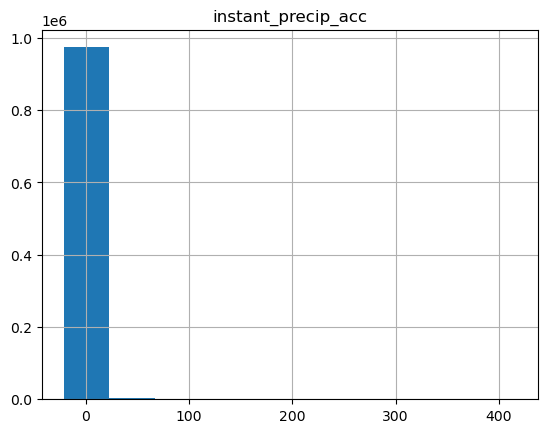

In [44]:
_temp_df["instant_precip_acc"].min(), _temp_df["instant_precip_acc"].max()
_temp_df.hist("instant_precip_acc");